<H1>Coursera IBM Applied Datascience Capstone</H1>

<H2>1. Introduction</H2>

I'm going to examine the differences in venue location between two vastly different cities. I'll compare Los Angeles, California and Burlington, Vermont. 

Burlington is the largest city in Chittenden County Vermont with a population of just over 42,000. Burlington houses the larges airport in Vermont and was the Nation's first city to fully convert to renewable energy.  The major industries in Burlington center around the University of Vermont, a private college, and its associated medical center. Additionaly, a few larger companies have software divisions located within Burlington.

Los Angeles, California has a population of 13.1 million people. Second only to New York as the most populous cities in the United States. In fact, Los Angeles county is the most populous county in the US. Los Angeles covers more than 460 square miles. With a gross metropolitan product of over 1 trillion dollars, LA is the third largest metopolitan economy in the world, larger than many countries. The economy of Los Angeles is driven largely by international trade with two of the largest ports in the world and by the entertainment industry. LA is also a major manufacturing center for the United States.

There are a lot of differences between these two cites. However, both cities have a significant eco-friendly emphasis, though not for the same things. Many such initiatives become trending in Los Angeles as people try to mimic the celebrities located there. Such efforts in Burlington draw decidely less attention, but seem to be more ingrained within the fabric of daily life.

Does the size of these cities and the differences in mindset impact the proximity of various venues to the center of these cities? Does a particular category of venue seem to predominate within each city?

<H2>2. Data</H2>

Exploratory venue data will be obtained for both cities from Foursquare. I'll use various Python libraries to look at the locations of these venues in relationship to the center of each city. I'll also compare the diversity of venues between the two cities.

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

!pip install folium
import folium

     |████████████████████████████████| 94 kB 4.3 MB/s  eta 0:00:01


In [2]:
# @hidden_cell

CLIENT_ID='ROOX3NJ34KEQE4EQLBAY1OXYIIXNHIYYJU1JCVGVPAW0PSVJ'
CLIENT_SECRET='CILQHFLRWG23B5JULVVYOIB13NWS3PDULBHJDE5OCPSO0VWF'
VERSION = '20210101'
LIMIT = 100

In [3]:
#Get locations for the two cities
ca_address="Los Angeles, California"
vt_address="Burlington, Vermont"

geolocator = Nominatim(user_agent="cn_explorer")

ca_location = geolocator.geocode(ca_address)
ca_latitude = ca_location.latitude
ca_longitude = ca_location.longitude

vt_location = geolocator.geocode(vt_address)
vt_latitude = vt_location.latitude
vt_longitude = vt_location.longitude

In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#function to get nearby venues for the two cities
def getNearbyVenues(name, latitude, longitude, radius=1000):
    
    venues_list = []
    print(name)
    
    searchType = 'explore'
    #create the API request
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&ll={}, {}&v={}&radius={}&limit={}&intent=browse'.format(
        searchType,
        CLIENT_ID,
        CLIENT_SECRET,
        latitude,
        longitude,
        VERSION,
        radius,
        LIMIT)

    #create the GET request
    result = requests.get(url).json()
    
    if searchType == 'explore':
        venues = result['response']['groups'][0]['items']
    else:
        if len(result['response']['venues'])==0:
            return('No tredning venues at this time')
        else:
            venues = result['response']['venues']
    
    nearby_venues = json_normalize(venues)
    
    #remove unwanted columns
    filtered_columns = ['venue.name', 'venue.location.lat', 'venue.location.lng', 'venue.categories']
    nearby_venues = nearby_venues.loc[:, filtered_columns]
    
    #get category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    
    #fix headers
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    return(nearby_venues)

In [5]:
#Get the nearby venues for the LA
LA_venues = getNearbyVenues(name="LA",
                                  latitude=ca_latitude,
                                  longitude=ca_longitude)

#Get the nearby venues for Burlington
burlington_venues = getNearbyVenues(name="Burlington",
                                  latitude=vt_latitude,
                                  longitude=vt_longitude)

LA
Burlington


In [6]:
LA_venues

,name,lat,lng,categories
0,Grand Park,34.055034,-118.245179,Park
1,Badmaash,34.051342,-118.244571,Indian Restaurant
2,Redbird,34.050666,-118.244068,American Restaurant
3,Kinokuniya Bookstore,34.050145,-118.242246,Bookstore
4,Birds & Bees,34.052090,-118.247376,Speakeasy
...,...,...,...,...
95,Sushi Zo,34.048148,-118.247188,Sushi Restaurant
96,RIF Los Angeles,34.048627,-118.240713,Shoe Store
97,The Blue Ribbon Garden,34.055561,-118.250241,Garden
98,Popkiller Second,34.048634,-118.240683,Boutique


In [7]:
burlington_venues

,name,lat,lng,categories
0,American Flatbread,44.476618,-73.214058,Pizza Place
1,Mad River Distillers Burlington,44.476062,-73.214180,Distillery
2,Onyx Tonics,44.477074,-73.214772,Coffee Shop
3,Burlington Farmers' Market,44.476528,-73.213548,Farmers Market
4,Friendly Toast,44.477422,-73.214131,Breakfast Spot
...,...,...,...,...
95,Champlain Farms,44.475733,-73.210558,Convenience Store
96,Speaking Volumes,44.468686,-73.216170,Record Shop
97,Earth Prime Comics,44.476081,-73.212514,Comic Shop
98,Shanty on the Shore,44.474400,-73.219006,Seafood Restaurant


<H2>3. Methods</H2>

Initial analysis of the data will begin by looking at the geographic distribution of the venues using geopy. I'll calculate a distance from city center for each venue and then summarize those by venue category and overall average distance. These distances will be compared between cities.

A comparison of categories will also be performed. Given the large difference in population between the two cities, this will be done via percentage. For example, what percentage of the venues are for coffee shops between the two cities and so forth.

Lastly, I'll look at the mix of trending venues between the two cities. This will be a more subjective measure in an attempt to see if the general type of trending venue differs between cities.

<H2>4. Results</H2>

In [8]:
from geopy import distance
#start by looking at distance from city center for each venue
#LA First
la_center = (ca_latitude, ca_longitude)
LA_venues['center_dist'] = [distance.distance((a, b), la_center).km for a, b in LA_venues[['lat', 'lng']].values]
LA_venues

,name,lat,lng,categories,center_dist
0,Grand Park,34.055034,-118.245179,Park,0.268012
1,Badmaash,34.051342,-118.244571,Indian Restaurant,0.309260
2,Redbird,34.050666,-118.244068,American Restaurant,0.356410
3,Kinokuniya Bookstore,34.050145,-118.242246,Bookstore,0.396289
4,Birds & Bees,34.052090,-118.247376,Speakeasy,0.461168
...,...,...,...,...,...
95,Sushi Zo,34.048148,-118.247188,Sushi Restaurant,0.738071
96,RIF Los Angeles,34.048627,-118.240713,Shoe Store,0.592777
97,The Blue Ribbon Garden,34.055561,-118.250241,Garden,0.720598
98,Popkiller Second,34.048634,-118.240683,Boutique,0.593004


In [9]:
#Burlington
burl_center = (vt_latitude, vt_longitude)
burlington_venues['center_dist'] = [distance.distance((a, b), burl_center).km for a, b in burlington_venues[['lat', 'lng']].values]
burlington_venues.head()

,name,lat,lng,categories,center_dist
0,American Flatbread,44.476618,-73.214058,Pizza Place,0.104825
1,Mad River Distillers Burlington,44.476062,-73.214180,Distillery,0.101947
2,Onyx Tonics,44.477074,-73.214772,Coffee Shop,0.179838
3,Burlington Farmers' Market,44.476528,-73.213548,Farmers Market,0.065400
4,Friendly Toast,44.477422,-73.214131,Breakfast Spot,0.170737


In [10]:
#average of all venues from city center
print("LA Average distance from city center:", LA_venues['center_dist'].mean())
print("Burlington distance from city center:", burlington_venues['center_dist'].mean())

LA Average distance from city center: 0.6118412536243748
Burlington distance from city center: 0.3623578324354507


In [11]:
#Now average by venue category for the two cities
la_grouped_avg = LA_venues.groupby('categories')['center_dist'].mean().to_frame()
burl_grouped_avg = burlington_venues.groupby('categories')['center_dist'].mean().to_frame()

In [12]:
combined_venue_avg = la_grouped_avg.merge(burl_grouped_avg, left_on='categories', right_on='categories', how='outer', sort='categories')
combined_venue_avg.columns = ['LA_dist','Burl_dist']
print("Here are the average distances for each venue category for both cities:")
combined_venue_avg

Here are the average distances for each venue category for both cities:


,LA_dist,Burl_dist
categories,,
Accessories Store,NaN,0.363700
American Restaurant,0.356410,0.203655
Aquarium,NaN,0.663499
Art Gallery,0.511891,NaN
Art Museum,0.678213,0.984886
...,...,...
Udon Restaurant,0.491567,NaN
Vegetarian / Vegan Restaurant,NaN,0.194302
Wine Shop,NaN,0.845053


In [13]:
#create dataframe for the categories the exist in both cities
combined_venue_avg_inner = la_grouped_avg.merge(burl_grouped_avg, left_on='categories', right_on='categories', how='inner', sort='categories')
combined_venue_avg_inner.columns = ['LA_dist','Burl_dist']
combined_venue_avg_inner

#perform t test on the average distances for the two cities
from scipy import stats
stats.ttest_ind(combined_venue_avg_inner['LA_dist'], combined_venue_avg_inner['Burl_dist'])


Ttest_indResult(statistic=4.064316810596382, pvalue=0.00019576491529601736)

In [14]:
#Now get a count of each venue category for the two cities
la_grouped_count = LA_venues[['name', 'categories']].groupby('categories').count()
burl_grouped_count = burlington_venues[['name', 'categories']].groupby('categories').count()
la_total = len(la_grouped_count.index)
burl_total = len(burl_grouped_count.index)
combined_venue_count = la_grouped_count.merge(burl_grouped_count, left_on='categories', right_on='categories', how='outer', sort='categories')
combined_venue_count.columns = ['LA_count','Burl_count']
combined_venue_count.fillna(0, inplace=True)
combined_venue_count['LA_pct'] = combined_venue_count['LA_count']/la_total
combined_venue_count['Burl_pct'] = combined_venue_count['Burl_count']/burl_total
print("The percentages of each venue category between the two cities are:")
combined_venue_count

The percentages of each venue category between the two cities are:


,LA_count,Burl_count,LA_pct,Burl_pct
categories,,,,
Accessories Store,0.0,1.0,0.000000,0.015152
American Restaurant,1.0,2.0,0.016949,0.030303
Aquarium,0.0,1.0,0.000000,0.015152
Art Gallery,1.0,0.0,0.016949,0.000000
Art Museum,1.0,1.0,0.016949,0.015152
...,...,...,...,...
Udon Restaurant,1.0,0.0,0.016949,0.000000
Vegetarian / Vegan Restaurant,0.0,2.0,0.000000,0.030303
Wine Shop,0.0,1.0,0.000000,0.015152


In [15]:
#Sort this dataframe for top 10 in LA
df_LA = combined_venue_count.sort_values(by=['LA_pct','categories'], ascending=False)
df_LA.head(10)

,LA_count,Burl_count,LA_pct,Burl_pct
categories,,,,
Sushi Restaurant,8.0,0.0,0.135593,0.000000
Japanese Restaurant,5.0,0.0,0.084746,0.000000
Coffee Shop,5.0,4.0,0.084746,0.060606
Ramen Restaurant,4.0,0.0,0.067797,0.000000
Mexican Restaurant,4.0,2.0,0.067797,0.030303
Theater,3.0,0.0,0.050847,0.000000
Plaza,3.0,0.0,0.050847,0.000000
Music Venue,3.0,1.0,0.050847,0.015152
Ice Cream Shop,3.0,2.0,0.050847,0.030303


In [16]:
#Sort this dataframe for top 10 in each city
df_Burl = combined_venue_count.sort_values(by=['Burl_pct','categories'], ascending=False)
df_Burl.head(10)

,LA_count,Burl_count,LA_pct,Burl_pct
categories,,,,
Pizza Place,2.0,5.0,0.033898,0.075758
Breakfast Spot,2.0,5.0,0.033898,0.075758
Coffee Shop,5.0,4.0,0.084746,0.060606
Hotel,0.0,3.0,0.000000,0.045455
Brewery,1.0,3.0,0.016949,0.045455
Bed & Breakfast,0.0,3.0,0.000000,0.045455
Bar,3.0,3.0,0.050847,0.045455
Bakery,1.0,3.0,0.016949,0.045455
Yoga Studio,0.0,2.0,0.000000,0.030303


<H2>5. Discussion</H2>

The most significant finding of this exercise was the difference in distance from city center for the venues in Los Angeles from those in Burlington. On Average, a venue was 0.6 meters from the center of Los Angeles versus about half of that in Burlington, Vermont. GThis difference was statistically different with a p value of 0.001. While these numbers are really quite small, one would expect the difference to be in the opposite direction. A large, highly populated city should be more compact with venues of all kinds packed closer together. Conversely, a smaller city surrounded by open space should, theoretically, be more spaced out. The above results show a small, but still significant trend in the opposite direction.

This is visually represented in the maps of the two cities, with the returned venues marked, below.

In [17]:
# create map
map_LA = folium.Map(location=[ca_latitude, ca_longitude], zoom_start=16)

# add markers to the map
markers_colors = []
for lat, lon, poi, cat in zip(LA_venues['lat'], LA_venues['lng'], LA_venues['name'], LA_venues['categories']):
    label = folium.Popup(str(poi) + ' - ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='Black',
        fill=True,
        fill_color='Blue',
        fill_opacity=0.7).add_to(map_LA)
print('Map of Los Angeles city center')
map_LA

Map of Los Angeles city center


In [18]:
#there are some clear clusters here, let's run a cluster analysis
la_clustered = LA_venues.copy()
la_clustered = la_clustered.drop(['name', 'lat', 'lng'], 1)
la_clustered.drop('categories',1, inplace=True)
la_clustered.reset_index()
la_clustered.set_index('center_dist')
la_clustered

,center_dist
0,0.268012
1,0.309260
2,0.356410
3,0.396289
4,0.461168
...,...
95,0.738071
96,0.592777
97,0.720598
98,0.593004


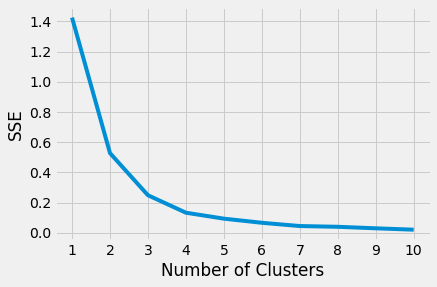

In [19]:
#K Means test. Find best fit.
import matplotlib.pyplot as plt

kmeans_test = {
    "init": "random",
    "n_init": 12,
    "max_iter": 300,
    "random_state": 0,
    }
 # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_test)
    kmeans.fit(la_clustered)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Best number of clusters is 3 or 4

In [23]:
#run the K Means algorithm
###test with 3 and 4 clusters
kclusters = 4
kmeans_la = KMeans(init='k-means++', n_clusters=kclusters, random_state=0, n_init=12).fit(la_clustered)
print('K Means Inertia (SSE):', kmeans_la.inertia_)

K Means Inertia (SSE): 0.13290920460464248


In [24]:
#add the kmeans labels to the dataframe
la_clustered_merged = LA_venues.copy()
la_clustered_merged.insert(0, "Cluster Labels", kmeans_la.labels_)
la_clustered_merged

,Cluster Labels,name,lat,lng,categories,center_dist
0,1,Grand Park,34.055034,-118.245179,Park,0.268012
1,1,Badmaash,34.051342,-118.244571,Indian Restaurant,0.309260
2,1,Redbird,34.050666,-118.244068,American Restaurant,0.356410
3,1,Kinokuniya Bookstore,34.050145,-118.242246,Bookstore,0.396289
4,1,Birds & Bees,34.052090,-118.247376,Speakeasy,0.461168
...,...,...,...,...,...,...
95,3,Sushi Zo,34.048148,-118.247188,Sushi Restaurant,0.738071
96,2,RIF Los Angeles,34.048627,-118.240713,Shoe Store,0.592777
97,0,The Blue Ribbon Garden,34.055561,-118.250241,Garden,0.720598
98,2,Popkiller Second,34.048634,-118.240683,Boutique,0.593004


In [29]:
la_clustered_merged.loc[la_clustered_merged['Cluster Labels']==0, la_clustered_merged.columns[[1] + list(range(5, la_clustered_merged.shape[1]))]]

,name,center_dist
17,Walt Disney Concert Hall,0.634749
21,Los Angeles Music Center,0.641807
22,Grand Central Market,0.645136
23,Dorothy Chandler Pavilion,0.652060
25,Ahmanson Theatre,0.655604
27,Mark Taper Forum,0.650649
28,Music Center Plaza,0.642929
29,The Broad,0.678213
30,The Colburn School of Performing Arts,0.631115
31,McConnell's Fine Ice Creams,0.650023


In [30]:
#clustered map
map_LA_clustered = folium.Map(location=[ca_latitude, ca_longitude], zoom_start=16)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_arr = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_arr]

# add markers to the map
markers_colors = []
for lat, lon, cat, cluster in zip(la_clustered_merged['lat'], la_clustered_merged['lng'], la_clustered_merged['categories'], la_clustered_merged['Cluster Labels']):
    label = folium.Popup(str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_LA_clustered)
print('Map of Los Angeles city center with clusters')
map_LA_clustered

Map of Los Angeles city center with clusters


In [31]:
# create map
map_VT = folium.Map(location=[vt_latitude, vt_longitude], zoom_start=16)

# add markers to the map
markers_colors = []
for lat, lon, poi, cat in zip(burlington_venues['lat'], burlington_venues['lng'], burlington_venues['name'], burlington_venues['categories']):
    label = folium.Popup(str(poi) + ' - ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='Black',
        fill=True,
        fill_color='Blue',
        fill_opacity=0.7).add_to(map_VT)
print('Map of Burlington city center')
map_VT

Map of Burlington city center


A close inspection of the two maps above shows that a partial explanation for this finding may be in how the venues are clustered within the two cities. The venues in Los Angeles are clustered dightly in a few groups, but these clusters are somewhat removed from the city center. Alternatively, the venues in Burlington seem to be rather evenly distributed around the city center with a few outlying venues on the outskirts of the city.

The two charts below show the top 10 venue categories, by percent. It's clear from these two charts and the data reported above that the two cities have dramatic differences in the venues closest to the city center. In the case of Burlington, one third of the venues were either breakfast spots or pizza shops. For LA, half of the venues were Sushi/Japanese restaraunts, Mexican restaraunts, or coffee shops. With Sushi and coffee joints making up more than half of these.

Clearly some different interests between these two cities. It's also interesting to note that despite LA's recent plant-based food craze, none of the 101 venues identified within 1000 meters of city center are vegan/vegetarian. Yet there are two of these within that same radius in Burlington.

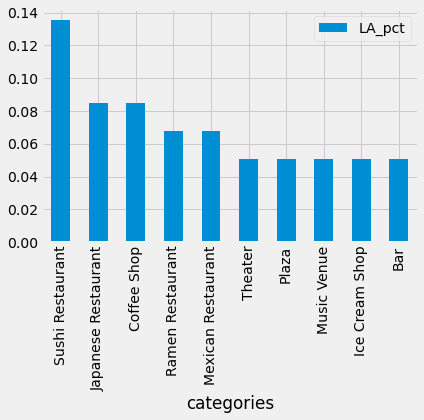

In [32]:
df_LA[0:10].plot.bar(y='LA_pct')

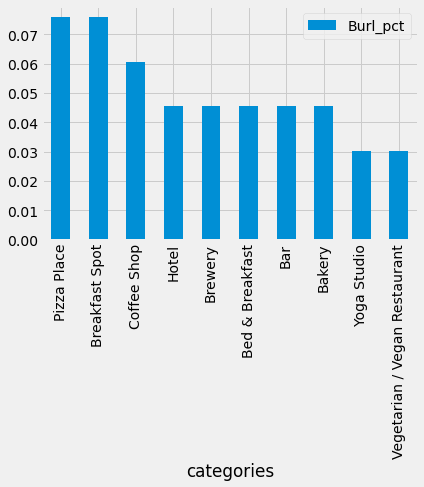

In [33]:
df_Burl[0:10].plot.bar(y='Burl_pct')

<H2>6. Conclusion</H2>

After reviewing all of the above information, maps and figures it's easy to see that these two cities are vastly different. While this is not really any surprise, some of the differences were unexpected, nonetheless. In particular, the density of venues seems opposite of what one might expect. The venues in LA are further from the city center than those of the much smaller, less dense Burlington. This appears to be mostly due to a difference in clustering. The venues in LA are in several distinct clusters a bit further from city center. Those in Burlington are more evenly distributed from the center, but not in any distinct clusters. 

Lastly, there are some differences in the types of restaraunts seen around the city centers of these two cities. There are more casual dinning options around Burlington city center and more finer dinning options in the center of LA.